# pip install

In [ ]:
pip install tflearn

     |████████████████████████████████| 112kB 2.9MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-cp37-none-any.whl size=127301 sha256=3a1d6f57ac3882c1a65124b82dd314ceae36658272e94f8d87e3e779ff3e7ba3
  Stored in directory: /root/.cache/pip/wheels/31/d2/ed/fb9a0d301dd9586c11e9547120278e624227f22fd5f4baf744
Successfully built tflearn


In [ ]:
# ls 'drive/MyDrive/AIHealthcare/facial_expression_recognition_using_cnn'
%cd drive/MyDrive/AIHealthcare/facial_expression_recognition_using_cnn

/content/drive/MyDrive/AIHealthcare/facial_expression_recognition_using_cnn


# Convert_fer2013_to_images_and_landmarks

In [ ]:
# !python convert_fer2013_to_images_and_landmarks.py --landmarks=yes --hog=no --hog_windows=no --jpg=no --expressions=1,4,6 (model2)
!python convert_fer2013_to_images_and_landmarks.py --landmarks=yes --hog=no --hog_windows=no --jpg=no 

In [ ]:
import numpy as np
import pandas as pd
import os
import argparse
import errno
import scipy.misc
import dlib
import cv2

from skimage.feature import hog

# initialization
image_height = 48
image_width = 48
window_size = 24
window_step = 6
ONE_HOT_ENCODING = True
SAVE_IMAGES = False
GET_LANDMARKS = False
GET_HOG_FEATURES = False
GET_HOG_IMAGES = False
GET_HOG_WINDOWS_FEATURES = False
SELECTED_LABELS = []
IMAGES_PER_LABEL = 500
OUTPUT_FOLDER_NAME = "fer2013_features"

# parse arguments and initialize variables:
# parser = argparse.ArgumentParser()
# parser.add_argument("-j", "--jpg", default="no", help="save images as .jpg files")
# parser.add_argument("-l", "--landmarks", default="yes", help="extract Dlib Face landmarks")
# parser.add_argument("-ho", "--hog", default="yes", help="extract HOG features")
# parser.add_argument("-hw", "--hog_windows", default="yes", help="extract HOG features from a sliding window")
# parser.add_argument("-hi", "--hog_images", default="no", help="extract HOG images")
# parser.add_argument("-o", "--onehot", default="yes", help="one hot encoding")
# parser.add_argument("-e", "--expressions", default="0,1,2,3,4,5,6", help="choose the faciale expression you want to use: 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral")
# args = parser.parse_args()
expressions = "0,1,2,3,4,5,6"

SAVE_IMAGES = False
GET_LANDMARKS = True
GET_HOG_FEATURES = False
GET_HOG_WINDOWS_FEATURES = False
GET_HOG_IMAGES = False
ONE_HOT_ENCODING = True

if expressions != "":
    expressions  = expressions.split(",")
    for i in range(0,len(expressions)):
        label = int(expressions[i])
        if (label >=0 and label<=6 ):
            SELECTED_LABELS.append(label)
if SELECTED_LABELS == []:
    SELECTED_LABELS = [0,1,2,3,4,5,6]
print( str(len(SELECTED_LABELS)) + " expressions")

# loading Dlib predictor and preparing arrays:
print( "preparing")
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
original_labels = [0, 1, 2, 3, 4, 5, 6]
new_labels = list(set(original_labels) & set(SELECTED_LABELS))
nb_images_per_label = list(np.zeros(len(new_labels), 'uint8'))
try:
    os.makedirs(OUTPUT_FOLDER_NAME)
    print(os.makedirs(OUTPUT_FOLDER_NAME))
except OSError as e:
    if e.errno == errno.EEXIST and os.path.isdir(OUTPUT_FOLDER_NAME):
        pass
    else:
        raise

def get_landmarks(image, rects):
    # this function have been copied from http://bit.ly/2cj7Fpq
    if len(rects) > 1:
        raise BaseException("TooManyFaces")
    if len(rects) == 0:
        raise BaseException("NoFaces")
    return np.matrix([[p.x, p.y] for p in predictor(image, rects[0]).parts()])

def get_new_label(label, one_hot_encoding=False):
    if one_hot_encoding:
        new_label = new_labels.index(label)
        label = list(np.zeros(len(new_labels), 'uint8'))
        label[new_label] = 1
        return label
    else:
        return new_labels.index(label)

def sliding_hog_windows(image):
    hog_windows = []
    for y in range(0, image_height, window_step):
        for x in range(0, image_width, window_step):
            window = image[y:y+window_size, x:x+window_size]
            hog_windows.extend(hog(window, orientations=8, pixels_per_cell=(8, 8),
                                            cells_per_block=(1, 1), visualise=False))
    return hog_windows

print( "importing csv file")
data = pd.read_csv('fer2013.csv')

for not category in data['Usage'].unique():
    print( "converting set: " + category + "...")
    # create folder
    print(os.path.exists(category))
    if os.path.exists(category):
        try:
            os.makedirs(OUTPUT_FOLDER_NAME + '/' + category)
        except OSError as e:
            if e.errno == errno.EEXIST and os.path.isdir(OUTPUT_FOLDER_NAME):
               pass
            else:
                raise
    
    # get samples and labels of the actual category
    category_data = data[data['Usage'] == category]
    samples = category_data['pixels'].values
    labels = category_data['emotion'].values
    
    # get images and extract features
    images = []
    labels_list = []
    landmarks = []
    hog_features = []
    hog_images = []
    for i in range(len(samples)):
        try:
            if labels[i] in SELECTED_LABELS and nb_images_per_label[get_new_label(labels[i])] < IMAGES_PER_LABEL:
                image = np.fromstring(samples[i], dtype=int, sep=" ").reshape((image_height, image_width))
                images.append(image)
                if SAVE_IMAGES:
                    cv2.imwrite(category + '/' + str(i) + '.jpg', image)
                if GET_HOG_WINDOWS_FEATURES:
                    features = sliding_hog_windows(image)
                    f, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                                            cells_per_block=(1, 1), visualise=True)
                    hog_features.append(features)
                    if GET_HOG_IMAGES:
                        hog_images.append(hog_image)
                elif GET_HOG_FEATURES:
                    features, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                                            cells_per_block=(1, 1), visualise=True)
                    hog_features.append(features)
                    if GET_HOG_IMAGES:
                        hog_images.append(hog_image)
                if GET_LANDMARKS:
                    cv2.imwrite('temp.jpg', image)
                    image2 = cv2.imread('temp.jpg')
                    face_rects = [dlib.rectangle(left=1, top=1, right=47, bottom=47)]
                    face_landmarks = get_landmarks(image2, face_rects)
                    landmarks.append(face_landmarks)            
                labels_list.append(get_new_label(labels[i], one_hot_encoding=ONE_HOT_ENCODING))
                nb_images_per_label[get_new_label(labels[i])] += 1
        except Exception as e:
            print( "error in image: " + str(i) + " - " + str(e))

    np.save(OUTPUT_FOLDER_NAME + '/' + category + '/images.npy', images)
    if ONE_HOT_ENCODING:
        np.save(OUTPUT_FOLDER_NAME + '/' + category + '/labels.npy', labels_list)
    else:
        np.save(OUTPUT_FOLDER_NAME + '/' + category + '/labels.npy', labels_list)
    if GET_LANDMARKS:
        np.save(OUTPUT_FOLDER_NAME + '/' + category + '/landmarks.npy', landmarks)
    if GET_HOG_FEATURES or GET_HOG_WINDOWS_FEATURES:
        np.save(OUTPUT_FOLDER_NAME + '/' + category + '/hog_features.npy', hog_features)
        if GET_HOG_IMAGES:
            np.save(OUTPUT_FOLDER_NAME + '/' + category + '/hog_images.npy', hog_images)

In [ ]:
import numpy as np
import pandas as pd
import os
import argparse
import errno
import scipy.misc
import dlib
import cv2
from tqdm.notebook import tqdm
from skimage.feature import hog

# initialization
image_height = 48
image_width = 48
window_size = 24
window_step = 6
ONE_HOT_ENCODING = True
SAVE_IMAGES = True
GET_LANDMARKS = True
GET_HOG_FEATURES = True
GET_HOG_IMAGES = True
GET_HOG_WINDOWS_FEATURES = True
SELECTED_LABELS = []
IMAGES_PER_LABEL = 500
OUTPUT_FOLDER_NAME = "fer2013_features"
from google.colab.patches import cv2_imshow

# parse arguments and initialize variables:
# parser = argparse.ArgumentParser()
# parser.add_argument("-j", "--jpg", default="no", help="save images as .jpg files")
# parser.add_argument("-l", "--landmarks", default="yes", help="extract Dlib Face landmarks")
# parser.add_argument("-ho", "--hog", default="yes", help="extract HOG features")
# parser.add_argument("-hw", "--hog_windows", default="yes", help="extract HOG features from a sliding window")
# parser.add_argument("-hi", "--hog_images", default="no", help="extract HOG images")
# parser.add_argument("-o", "--onehot", default="yes", help="one hot encoding")
# parser.add_argument("-e", "--expressions", default="0,1,2,3,4,5,6", help="choose the faciale expression you want to use: 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral")

expressions = "0,1,2,3,4,5,6"

SAVE_IMAGES = False
GET_LANDMARKS = True
GET_HOG_FEATURES = False
GET_HOG_WINDOWS_FEATURES = False
GET_HOG_IMAGES = False
ONE_HOT_ENCODING = True

if expressions != "":
    expressions  = expressions.split(",")
    for i in range(0,len(expressions)):
        label = int(expressions[i])
        if (label >=0 and label<=6 ):
            SELECTED_LABELS.append(label)
if SELECTED_LABELS == []:
    SELECTED_LABELS = [0,1,2,3,4,5,6]
print( str(len(SELECTED_LABELS)) + " expressions")

# loading Dlib predictor and preparing arrays:
print( "preparing")
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
original_labels = [0, 1, 2, 3, 4, 5, 6]
new_labels = list(set(original_labels) & set(SELECTED_LABELS))
nb_images_per_label = list(np.zeros(len(new_labels), 'uint8'))

try:
    os.makedirs(OUTPUT_FOLDER_NAME)
except OSError as e:
    if e.errno == errno.EEXIST and os.path.isdir(OUTPUT_FOLDER_NAME):
        pass
    else:
        raise

def get_landmarks(image, rects):
    if len(rects) > 1:
        raise BaseException("TooManyFaces")
    if len(rects) == 0:
        raise BaseException("NoFaces")
    return np.matrix([[p.x, p.y] for p in predictor(image, rects[0]).parts()])

def get_new_label(label, one_hot_encoding=False):
    if one_hot_encoding:
        new_label = new_labels.index(label)
        label = list(np.zeros(len(new_labels), 'uint8'))
        label[new_label] = 1
        return label
    else:
        return new_labels.index(label)

def sliding_hog_windows(image):
    hog_windows = []
    for y in range(0, image_height, window_step):
        for x in range(0, image_width, window_step):
            window = image[y:y+window_size, x:x+window_size]
            hog_windows.extend(hog(window, orientations=8, pixels_per_cell=(8, 8),
                                            cells_per_block=(1, 1), visualize=False))
    return hog_windows

print( "importing csv file")
data = pd.read_csv('fer2013.csv')

for category in data['Usage'].unique():
    print( "converting set: " + category + "...")
    # create folder
    if not os.path.exists(category):
        try:
            os.makedirs(OUTPUT_FOLDER_NAME + '/' + category)
            print('OK')
        except OSError as e:
            if e.errno == errno.EEXIST and os.path.isdir(OUTPUT_FOLDER_NAME):
               pass
            else:
                raise
    
    # get samples and labels of the actual category
    category_data = data[data['Usage'] == category]
    samples = category_data['pixels'].values
    labels = category_data['emotion'].values
    
    # get images and extract features
    images = []
    labels_list = []
    landmarks = []
    hog_features = []
    hog_images = []
    for i in tqdm(range(len(samples))):
        try:
            if labels[i] in SELECTED_LABELS and nb_images_per_label[get_new_label(labels[i])] < IMAGES_PER_LABEL:
                image = np.fromstring(samples[i], dtype=int, sep=" ").reshape((image_height, image_width))
                images.append(image)
                if SAVE_IMAGES:
                    cv2.imwrite(category + '/' + str(i) + '.jpg', image)
                    cv2_imshow(image)
                if GET_HOG_WINDOWS_FEATURES:
                    features = sliding_hog_windows(image)
                    f, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualize=True)
                    hog_features.append(features)
                    if GET_HOG_IMAGES:
                        hog_images.append(hog_image)
                if GET_HOG_FEATURES:
                    features, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualize=True)
                    hog_features.append(features)
                    if GET_HOG_IMAGES:
                        hog_images.append(hog_image)
                if GET_LANDMARKS:
                    cv2.imwrite('temp.jpg', image)
                    image2 = cv2.imread('temp.jpg')
                    face_rects = [dlib.rectangle(left=1, top=1, right=47, bottom=47)]
                    face_landmarks = get_landmarks(image2, face_rects)
                    landmarks.append(face_landmarks)            
                labels_list.append(get_new_label(labels[i], one_hot_encoding=ONE_HOT_ENCODING))
                nb_images_per_label[get_new_label(labels[i])] += 1
        except Exception as e:
            print( "error in image: " + str(i) + " - " + str(e))

    np.save(OUTPUT_FOLDER_NAME + '/' + category + '/images.npy', images)
    if ONE_HOT_ENCODING:
        np.save(OUTPUT_FOLDER_NAME + '/' + category + '/labels.npy', labels_list)
    else:
        np.save(OUTPUT_FOLDER_NAME + '/' + category + '/labels.npy', labels_list)
    if GET_LANDMARKS:
        np.save(OUTPUT_FOLDER_NAME + '/' + category + '/landmarks.npy', landmarks)
    if GET_HOG_FEATURES or GET_HOG_WINDOWS_FEATURES:
        np.save(OUTPUT_FOLDER_NAME + '/' + category + '/hog_features.npy', hog_features)
        if GET_HOG_IMAGES:
            np.asarray(OUTPUT_FOLDER_NAME + '/' + category + '/hog_images.npy', hog_images)

7 expressions
preparing
importing csv file
converting set: Training...



converting set: PublicTest...
OK



converting set: PrivateTest...
OK


# Train

In [ ]:
# !python train.py --train=yes

In [ ]:
# python train.py --train=yes --evaluate=yes

# Optimizer

In [ ]:
# !python optimize_hyperparams.py --max_evals=20

# inference

In [ ]:
!python predict.py --image img/kaka.jpg

2021-05-24 08:38:13.995947: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Instructions for updating:
non-resource variables are not supported in the long term
loading pretrained model...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
2021-05-24 08:38:21.074837: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-24 08:38:21.076121: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library 

In [ ]:
# x1
# from numpy import zeros, newaxis
# image = cv2.imread('img/kaka.jpg',0)
# image = cv2.resize(image,(48,48))
# print(image[newaxis,:, : ].shape)
# data_dict['X'] = image[newaxis,:, : ]
# data_dict['X'] = data_dict['X'].reshape([-1, NETWORK.input_size, NETWORK.input_size, 1])  
# print(data_dict['X'].shape)  

# # x2
# data_dict['X2'] = np.load(DATASET.train_folder + '/landmarks.npy')
# print(data_dict['X2'].shape)

(3436, 48, 48)
(3436, 48, 48, 1)


Instructions for updating:
non-resource variables are not supported in the long term
loading pretrained model...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/AIHealthcare/facial_expression_recognition_using_cnn/best_model/saved_model.bin


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Prediction: Surprise (confidence: 100.0%)
time: 1.2 sec


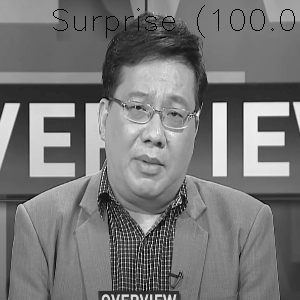

In [ ]:
import tensorflow as tf
from tflearn import DNN
import time
import numpy as np
import argparse
import dlib
import cv2
import os
from skimage.feature import hog
from numpy import zeros, newaxis
from parameters import DATASET, TRAINING, NETWORK, VIDEO_PREDICTOR
from model import build_model
from google.colab.patches import cv2_imshow

window_size = 24
window_step = 6

def load_model():
    model = None
    with tf.Graph().as_default():
        print( "loading pretrained model...")
        network = build_model()
        model = DNN(network)
        if os.path.isfile(TRAINING.save_model_path):
            model.load(TRAINING.save_model_path)
        else:
            print( "Error: file '{}' not found".format(TRAINING.save_model_path))
    return model

def get_landmarks(image, rects, predictor):
    if len(rects) > 1:
        raise TooManyFaces
    if len(rects) == 0:
        raise NoFaces
    return np.matrix([[p.x, p.y] for p in predictor(image, rects[0]).parts()])

def sliding_hog_windows(image):
    hog_windows = []
    for y in range(0, NETWORK.input_size, window_step):
        for x in range(0, NETWORK.input_size, window_step):
            window = image[y:y+window_size, x:x+window_size]
            hog_windows.extend(hog(window, orientations=8, pixels_per_cell=(8, 8),
                                            cells_per_block=(1, 1), visualize=False))
    return hog_windows

def predict(image, model, shape_predictor=None):
    image = cv2.resize(image,(NETWORK.input_size,NETWORK.input_size))
    
    # get landmarks
    if NETWORK.use_landmarks or NETWORK.use_hog_and_landmarks or NETWORK.use_hog_sliding_window_and_landmarks:
        face_rects = [dlib.rectangle(left=0, top=0, right=NETWORK.input_size, bottom=NETWORK.input_size)]
        face_landmarks = np.array([get_landmarks(image, face_rects, shape_predictor)])
        features = face_landmarks
        
        if NETWORK.use_hog_sliding_window_and_landmarks: 
            hog_features = sliding_hog_windows(image)
            hog_features = np.asarray(hog_features)
            face_landmarks = face_landmarks.flatten()
            features = np.concatenate((face_landmarks, hog_features))
        elif NETWORK.use_hog_and_landmarks:
            hog_features, _ = hog(image, orientations=8, pixels_per_cell=(16, 16),
                                    cells_per_block=(1, 1), visualize=True)
            hog_features = np.asarray(hog_features)
            face_landmarks = face_landmarks.flatten()
            features = np.concatenate((face_landmarks, hog_features))


        image = image[newaxis,:, : ]
        tensor_image = image.reshape([-1, NETWORK.input_size, NETWORK.input_size, 1])

        predicted_label = model.predict([tensor_image, features])
        # predicted_label = model.predict([tensor_image, features.reshape((1, -1))])
        return get_emotion(predicted_label[0])
    else:
        tensor_image = image.reshape([-1, NETWORK.input_size, NETWORK.input_size, 1])
        predicted_label = model.predict(tensor_image)
        return get_emotion(predicted_label[0])
    return None

def get_emotion(label):
    if VIDEO_PREDICTOR.print_emotions:
        print( "- Angry: {0:.1f}%\n- Happy: {1:.1f}%\n- Sad: {2:.1f}%\n- Surprise: {3:.1f}%\n- Neutral: {4:.1f}%".format(
                label[0]*100, label[1]*100, label[2]*100, label[3]*100, label[4]*100))
    label = label.tolist()
    return VIDEO_PREDICTOR.emotions[label.index(max(label))], max(label)

model = load_model()
image = cv2.imread('img/sad.png', 0)
shape_predictor = dlib.shape_predictor(DATASET.shape_predictor_path)
start_time = time.time()
emotion, confidence = predict(image, model, shape_predictor)
total_time = time.time() - start_time
print( "Prediction: {0} (confidence: {1:.1f}%)".format(emotion, confidence*100))
print( "time: {0:.1f} sec".format(total_time))
image = cv2.resize(image,(300,300))
TEXT_COLOR = (0, 255, 0)
text = "{0} ({1:.1f}%)".format(emotion, confidence*100)
cv2.putText(image, text,(50,30),cv2.FONT_HERSHEY_SIMPLEX, 1, TEXT_COLOR, 1)
cv2_imshow(image)

In [ ]:
# !python predict-from-video.py

In [ ]:
ls 'img'

CNN_models_architecture.png   FER2013_strange_samples.png  sad.png
fer2013_incorrect_labels.png  kaka.jpg
